In [2]:
import sys, os, time
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import networkx as nx
import colour as co
import math

# %% Load the calcium imaging dataset

datadir = 'data/dataset3_m62/'
trackdata = io.loadmat(datadir+'downTrackdata.mat')
phi = trackdata['phi']; x = trackdata['x']; y = trackdata['y']; r=trackdata['r'];
speed = trackdata['speed']; t = trackdata['time'];
spikedata = io.loadmat(datadir+'spikes.mat')
spikes = spikedata['spikes']
params = spikedata['params']
fluodata = io.loadmat(datadir+'fissa_output.mat')
dfonf = fluodata['ddf_f']

FileNotFoundError: [Errno 2] No such file or directory: 'data/dataset3_m62/downTrackdata.mat'

~ Plot as a square image the matrix of Pearson correlation coefficients between the calcium fluorescence time series from each cell 

In [3]:
#determine the Pearson correlation coefficients matrix of the calcium fluoresence time series from each cell 
PCC = np.corrcoef (dfonf)

#plot the matrix as a square image 
plt.figure(figsize=(10,15))  #create a figure 
img = plt.imshow(PCC, interpolation='none', cmap='inferno')  #magma ou cividis AUSSI 
cbar = plt.colorbar(img, shrink=0.5, pad=0.13)   #create a colorbar 
cbar.set_label('Pearson Correlation Coefficients (PCC)', labelpad=5, fontsize = 15)
plt.title("Matrix of Pearson Correlation Coefficients ", fontsize = 15)
plt.xlabel('Number of the cell', fontsize = 10) 
plt.ylabel('Number of the cell', fontsize = 10)
plt.clim (-1,1)   #set a range between -1 to 1 

NameError: name 'dfonf' is not defined

~ Plot the distribution of correlation coefficients 

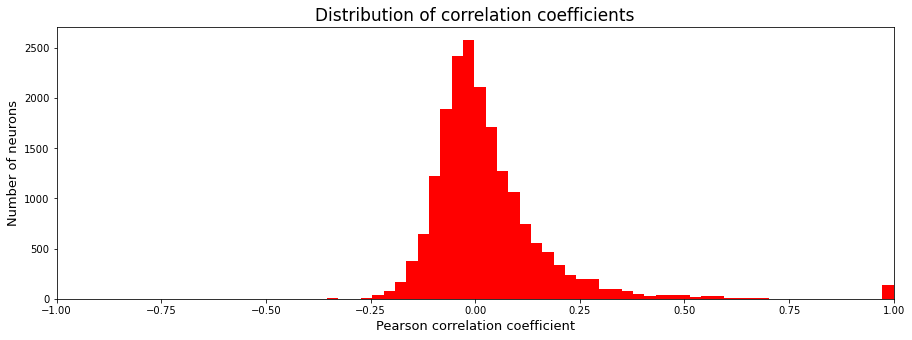

In [45]:
plt.figure(figsize=(15,5))
plt.hist(PCC.flatten(), bins=50, density=False, color='red')  #plot the histogram of PCC values obtained above #make the matrix 1D through flattening 
plt.title('Distribution of correlation coefficients', fontsize = 17)
plt.xlabel('Pearson correlation coefficient', fontsize = 13)
plt.xlim(-1,1)   #set a range between -1 and 1 
plt.ylabel('Number of neurons', fontsize = 13)
plt.show()

~ Form an undirected graph representing binary correlation coefficients between the time series, 1 couting the correlation coefficients exceeding the 80th percentile of the distribution between different neurons

In [46]:
#determine the 80th percentile of the distribution between different neurons 
np.fill_diagonal(PCC,0)     #remove the diagonal from the correlations (=self edges)
thresh = np.percentile(PCC, 80)      #create a threshold of the 80th value
print("The 80th percentile of the distribution is:", thresh)

The 80th percentile of the distribution is: 0.09259937669106649


Once the 80th percentile of the distribution was computed, we were able to plot the adjacency matrix as image, enabling us to visualise the edges of the PCC distribution. The edges represent the binary variable where the PCC takes a value of 1 in the case of the time series exceeding 80th percentile of distribution between each neurons. The self-edges represent the autocorrelation coefficients, and have been removed from the original matrix. Therefore, the PCC was filtered along these requirements and only values above 0.0926 were taken into consideration. The number of edges were then computed to have a general idea of the proportion of edges in the matrix. 

Number of edges in the adjacency matrix is : 3808


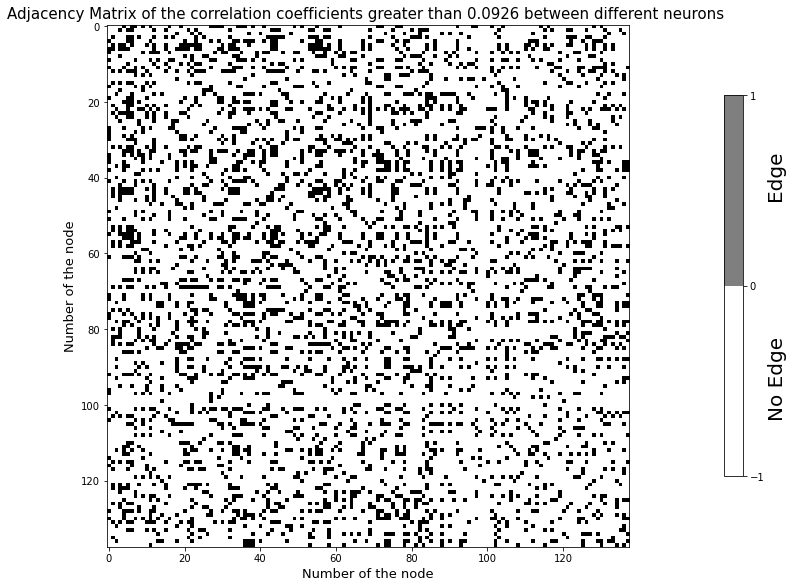

In [52]:
#filter the PCC - take everything above the thresh computed above (=80th percentile)
PCC_filtered = PCC > thresh

#compute number of edges 
degree = np.sum(PCC_filtered,1)
edges = sum(degree)    
print("Number of edges in the adjacency matrix is :", edges )

#create the adjency matrix as an image - taking into account only the PCC previously filtered
plt.figure(figsize=(13,10))   #create a figure 
img = plt.imshow(PCC_filtered, cmap='binary')
plt.title("Adjacency Matrix of the correlation coefficients greater than 0.0926 between different neurons ", fontsize = 15)
plt.xlabel('Number of the node', fontsize = 13) 
plt.ylabel('Number of the node', fontsize = 13)
cbar = plt.colorbar(img, boundaries=[-1,0,1],shrink=0.7, pad=0.13)   #create a colorbar 
cbar.set_label('No Edge                     Edge',fontsize = 20)



(-1.0997239429241432,
 1.0999868544249591,
 -1.099927696961035,
 1.099927696961035)

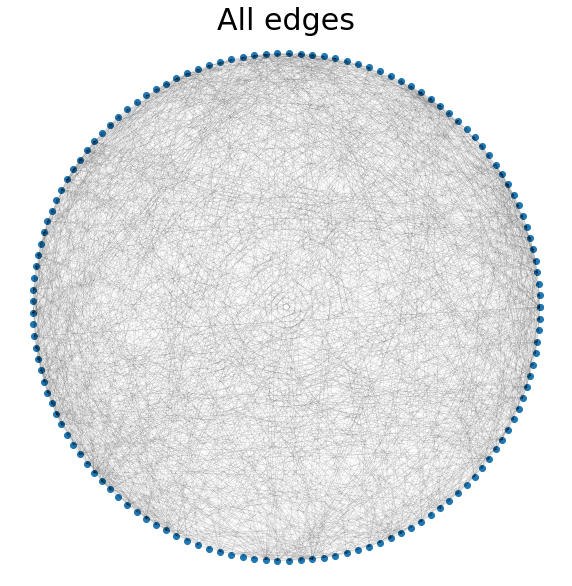

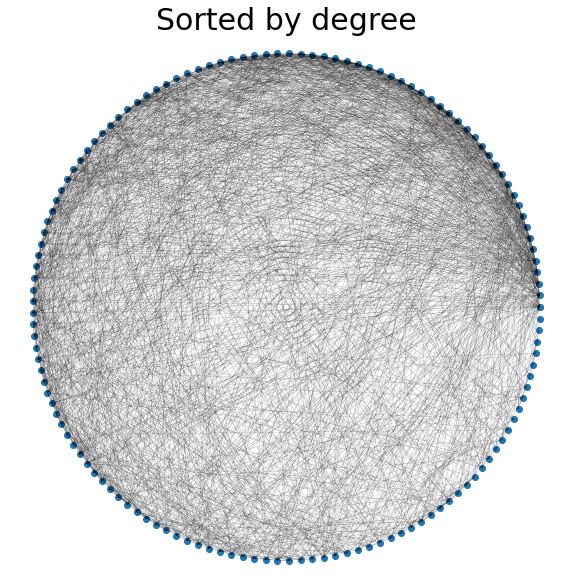

In [53]:
#plot a circle plot as another graph visualisation method
def circleplot(Adj):        #create a function to generate a circle plot  
    
    numb_vertices = len(Adj[:,1])
    degree = np.sum(Adj,1)

    theta = np.linspace(0,2*np.pi,numb_vertices)
    x = np.cos((theta))

    y = np.sin((theta))
    
    plt.figure(figsize=(10,10))
    plt.scatter(x,y)

    for i in range(numb_vertices):

        for col in range(i,numb_vertices):
            if (degree[i]>0):
                if (Adj[i,col]==1):

                    plt.plot([x[i],x[col]],[y[i],y[col]], linewidth=0.05, color = 'k')
    plt.title("All edges", fontsize=30)
    plt.show
    plt.axis("equal")
    

def circleplotsorted(Adj):
    numb_vertices = len(Adj[:,1])
    degree = np.sum(Adj,1)
    
    sortedVertices = np.argsort(degree)[::-1]
    theta = np.linspace(0,2*np.pi,numb_vertices)
    x = np.cos((theta))

    y = np.sin((theta))
    
    plt.figure(figsize=(10,10))
    plt.scatter(x,y)

    for i in sortedVertices:
        if degree[i]>0:
            for col in range(i,numb_vertices):
                if (Adj[i,col]==1):
                    start = np.where(sortedVertices==i)[0]
                    end = np.where(sortedVertices == col)[0]
                    plt.plot([x[start],x[end]],[y[start],y[end]], linewidth=0.1, color = 'k')

    plt.title("Sorted by degree", fontsize=30)
    plt.show
    plt.axis("equal")
    
#plot the graph with all the connections 
circleplot(PCC_filtered)   #with all edges 
plt.axis('off')
circleplotsorted(PCC_filtered)      #this time sorted by degree 
plt.axis('off') 


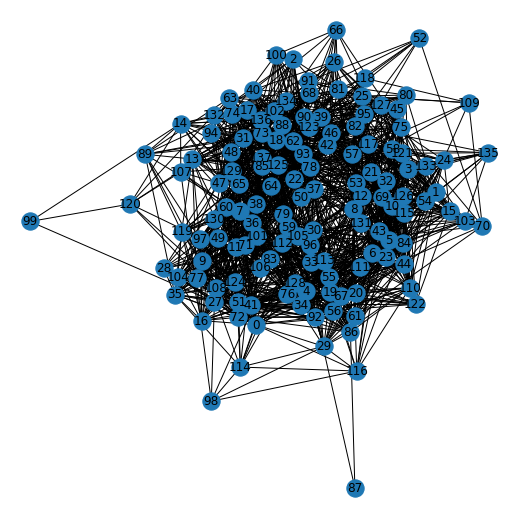

In [10]:
#plot the network representation as another graph visualisation method 

G = nx.Graph(PCC_filtered)   #create the network graph with the filtered PCC 
plt.figure(figsize=(7,7))    #create the figure
nx.draw(G, with_labels=True)     #generate the graph 

~ Determine the average degree 𝑘 for the network described by the adjacency matrix 

In [54]:
#computation of the average degree of the filtered PCC
numb_vertices = len(PCC_filtered)     #compute number of vetrices in the network
degree = np.sum(PCC_filtered,1)     #compute the different degrees of the network 
edges = sum(degree)      
K = edges/numb_vertices     #compute the average degree 
print("The average degree k of our network is:", K)    #print k 

The average degree k is: 27.594202898550726


~ Determine the global average clustering coefficient

In [30]:
#compute the average of the graph's cluster coefficient
avg_cluster = nx.average_clustering(G)    
print ("The average cluster coefficient is:", avg_cluster)

The average cluster coefficient is: 0.4896837428141971


In [57]:
#compute the average cluster coeff of a random network using the ER network 
ERcluster = K / numb_vertices
print ("Average Cluster Coefficient of a random network:", ERcluster)

Average Cluster Coefficient of a random network: 0.19995799201848352


~ Determine the network diameter D

In [60]:
#calculate the network diameter 
D = nx.diameter(G, e=None, usebounds=False)
print("The network diameter is:", D)

#calculate the average shortest path of the network
avg_shortpath = nx.average_shortest_path_length (G)
print("The average shortest path of the network is:", avg_shortpath)

The network diameter is: 4
The average shortest path of the network is: 1.9198138157198772


~ Plot the degree distribution for the network 

/opt/anaconda3/envs/NE/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


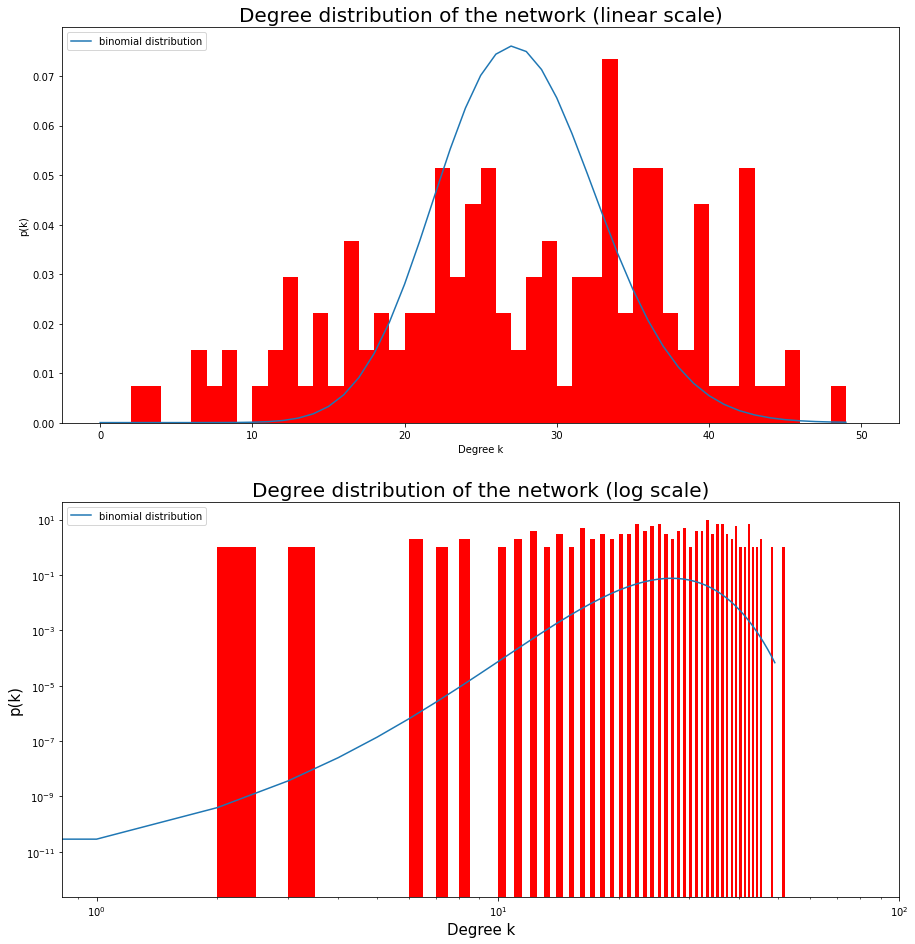

In [65]:
#plot degree distribution
def poisson(meank,k):     #create a function to determine the Poisson binomial distribution 
    return meank**k * math.exp(-1*meank)/math.factorial(k)


# Function for the overlay the histogram with a poisson distribution with the same mean
x = np.array(range(0,50,1))
poi = []
for k in range(len(x)):
    poi.append(poisson(K,k))       


plt.figure(1,figsize=(15,16))    #create the figure 

plt.subplot(211)

#plot for linear hist 
hist = plt.hist(degree,range =(0,50), bins=50,density=True, color="red")

plt.title('Degree distribution of the network (linear scale)',fontsize=20)
plt.xlabel("Degree k", fontsize=15)
plt.ylabel("p(k)", fontsize=15)
plt.plot(x,poi, label='binomial distribution')
plt.legend(loc='upper left') # add a legend for the poisson overlay


#plot for log hist 

plt.subplot(212)

plt.xscale('log')
plt.hist(degree, bins=100, color="red")
plt.plot(x,poi, label='binomial distribution')
plt.title('Degree distribution of the network (log scale)',fontsize=20)
plt.xlabel('Degree k', fontsize=15)
plt.xscale("log")
plt.ylabel('p(k)', fontsize=15)
plt.yscale("log")
plt.legend(loc='upper left') # add a legend for the poisson overlay
plt.xlim(0, 100)

plt.show()